# Data Extraction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!unzip -q /content/drive/MyDrive/monkey/data.zip train_annotation.json val_annotation.json -d data/
!unzip -q /content/drive/MyDrive/monkey/data.zip train/* val/* -d data/

# Imports

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


# Config Setup

In [ ]:
class config:
    RANDOM_STATE = 12
    BATCH_SIZE = 256
    NUM_WORKERS = 12
    IMAGE_HEIGHT = 128
    IMAGE_WIDTH = 128
    LEARNING_RATE = 1e-4
    EPOCHS = 5

# Data Loading and Processing

In [ ]:
train_annot = json.load(open("data/train_annotation.json"))
train_df = pd.DataFrame(train_annot["data"])

val_annot = json.load(open("data/val_annotation.json"))
val_df = pd.DataFrame(val_annot["data"])

train_df["file"] = "data/train/train/" + train_df["file"]
val_df["file"] = "data/val/val/" + val_df["file"]

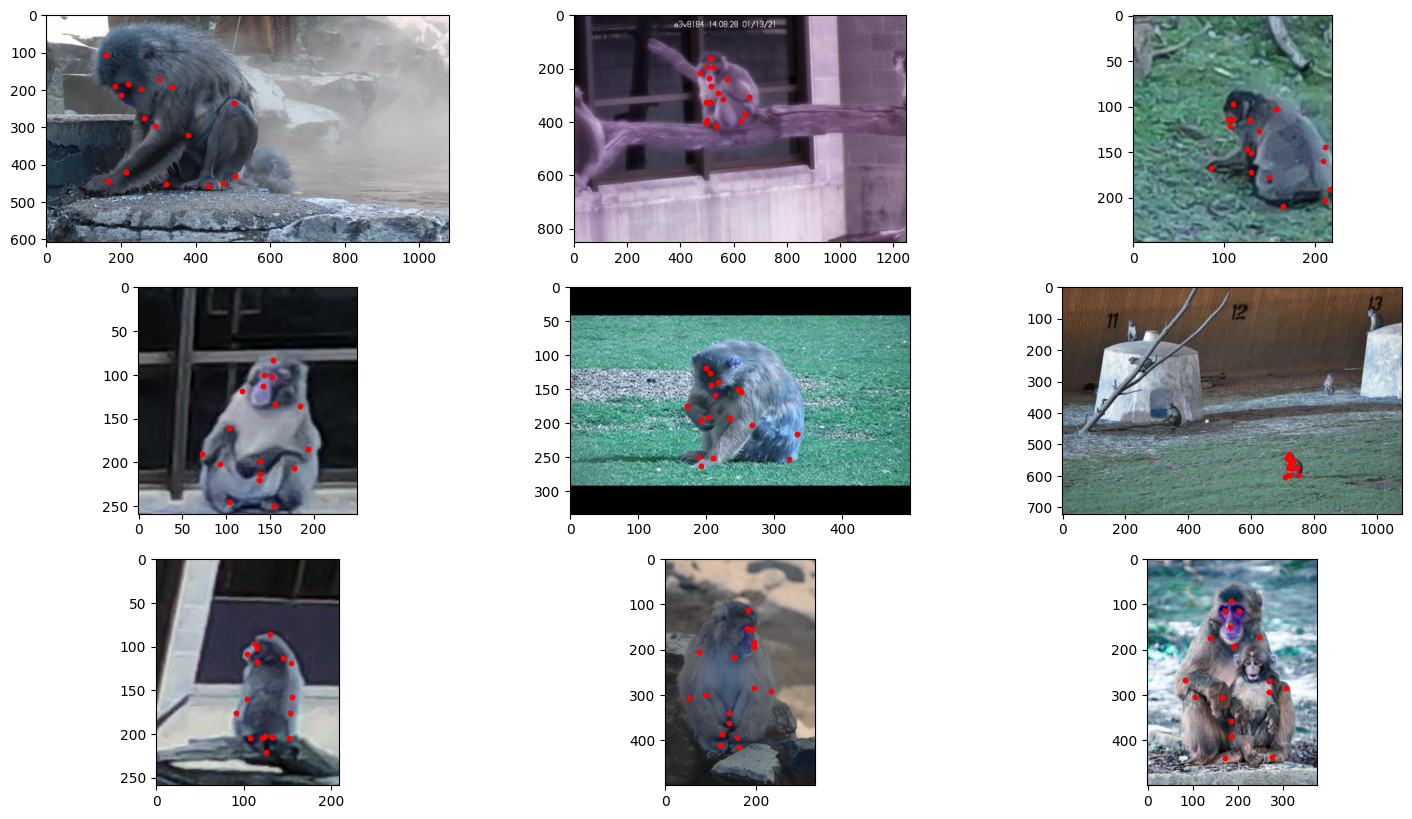

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (18, 10))

paths = [ train_df.iloc[i]["file"] for i in range(9)]
landmarks = [train_df.iloc[i]["landmarks"] for i in range(9)]
landmarks = [np.array(landmark).reshape(-1, 2) for landmark in landmarks]

# Flatten the axes array for easy indexing
axs = axs.flatten()

for i in range(len(paths)):
    image = cv2.imread(paths[i])
    landmark = landmarks[i]
    
    # Reshape the landmarks into an array of shape (17, 2)
    landmark = np.array(landmark).reshape(-1, 2)

    # Plot the image
    axs[i].imshow(image)

    # Plot the landmarks
    x = landmark[:, 0]
    y = landmark[:, 1]
    axs[i].scatter(x, y, s=10, c='red', marker='o')

# Hide the empty subplots
for i in range(len(paths), len(axs)):
    axs[i].axis('off')

# Show the plot
plt.show()

## Custom Dataset

In [ ]:
class PoseEstimationDataset(Dataset):
    def __init__(self, dataframe, image_height, image_width, transform=None):
        self.image_height = image_height
        self.image_width = image_width
        self.images = dataframe.reset_index(drop = True)["file"]
        self.landmarks = dataframe.reset_index(drop = True)["landmarks"]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        landmark = self.landmarks[idx]

        # Preprocess the image and landmark
        image, landmark = self.preprocess(image, landmark)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(landmark)

    def preprocess(self, image, landmark):
        # Resize image and scale landmarks
        original_width, original_height = image.size
        new_size = (self.image_height, self.image_width)
        image = image.resize(new_size)

        landmark = [landmark[i] * (new_size[i % 2] / original_width) if i % 2 == 0 else landmark[i] * (new_size[i % 2] / original_height) for i in range(len(landmark))]

        return image, landmark

## Loading Dataloaders

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset and dataloader
train_dataset = PoseEstimationDataset(
    train_df, 
    config.IMAGE_HEIGHT,
    config.IMAGE_WIDTH,
    transform=transform)

val_dataset = PoseEstimationDataset(
    val_df, 
    config.IMAGE_HEIGHT,
    config.IMAGE_WIDTH,
    transform=transform
    )


train_dataloader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=config.NUM_WORKERS
    )

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=config.NUM_WORKERS
    )

# Modelling

In [ ]:
class PoseEstimationResNet(nn.Module):
    def __init__(self, num_landmarks=17):
        super(PoseEstimationResNet, self).__init__()
        resnet = models.resnet50(pretrained=True)  # You can choose a different ResNet variant if needed

        # Remove the last fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Create a new fully connected layer for regression
        self.fc = nn.Linear(resnet.fc.in_features, num_landmarks * 2)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss / 34


def test_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, targets)

            running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss/ 34 

In [ ]:
# Initialize the model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PoseEstimationResNet()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
test_losses = []

# Training loop
for epoch in tqdm(range(config.EPOCHS)):
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, device)
    test_loss = test_epoch(model, val_dataloader, criterion, device)

    #Append losses to the lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{config.EPOCHS}] - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [1/5] - Train Loss: 76.3981 - Test Loss: 25.7601


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [2/5] - Train Loss: 15.5107 - Test Loss: 10.9445


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [3/5] - Train Loss: 9.2215 - Test Loss: 8.6033


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [4/5] - Train Loss: 7.6472 - Test Loss: 6.9269


  0%|          | 0/262 [00:00<?, ?it/s]

Epoch [5/5] - Train Loss: 5.8584 - Test Loss: 5.6147


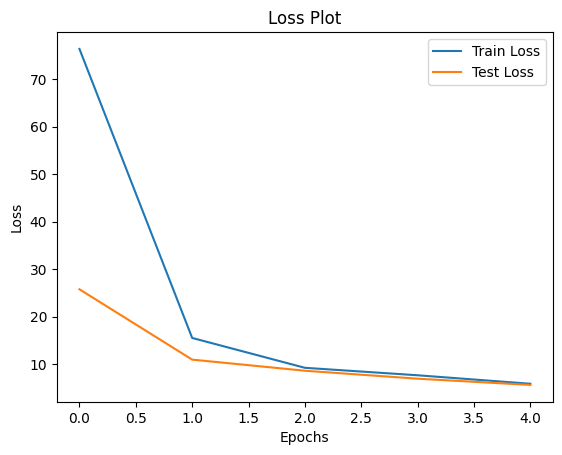

In [ ]:
plt.plot(train_losses, label = "Train Loss")
plt.plot(test_losses, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.legend()
plt.show()

## Evaluation 

In [ ]:
def mean_squared_error(gt_labels, pred_labels):
    return np.mean(np.square(gt_labels - pred_labels)) / 34

def mean_absolute_error(gt_labels, pred_labels):
    return np.mean(np.abs(gt_labels - pred_labels)) / 34

def percentage_of_correct_keypoints(gt_labels, pred_labels, threshold):
    batch_size = gt_labels.shape[0]
    n_keypoints = gt_labels.shape[1] // 2

    gt_keypoints = gt_labels.reshape(batch_size, n_keypoints, 2)
    pred_keypoints = pred_labels.reshape(batch_size, n_keypoints, 2)

    distances = np.sqrt(np.sum((gt_keypoints - pred_keypoints)**2, axis=-1))
    correct_keypoints = (distances <= threshold).sum()

    return correct_keypoints / (batch_size * n_keypoints)

def mean_per_joint_position_error(gt_labels, pred_labels):
    batch_size = gt_labels.shape[0]
    n_keypoints = gt_labels.shape[1] // 2

    gt_keypoints = gt_labels.reshape(batch_size, n_keypoints, 2)
    pred_keypoints = pred_labels.reshape(batch_size, n_keypoints, 2)

    distances = np.sqrt(np.sum((gt_keypoints - pred_keypoints)**2, axis=-1))
    mean_distances = distances.mean()

    return mean_distances

def infer_model(model, dataloader):
    preds = np.ones((0,34))
    labels = np.ones((0,34))
    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = np.append(preds, outputs.cpu().numpy(), 0)
            labels = np.append(labels, targets.cpu().numpy(), 0)
    return labels, preds

In [ ]:
print("Starting Model Evaluation!")
labels, preds = infer_model(model, val_dataloader)
print()
print("Mean Absolute Error = ", mean_absolute_error(labels, preds))
print("Mean Squared Error = ", mean_squared_error(labels, preds))
print("Mean Per Joint Position Error = ", mean_per_joint_position_error(labels, preds))
print("Percentage of Correct Keypoints at 5% Threshold = ", percentage_of_correct_keypoints(labels, preds , 0.05 * config.IMAGE_HEIGHT)*100)
print("Percentage of Correct Keypoints at 10% Threshold = ", percentage_of_correct_keypoints(labels, preds , 0.10 * config.IMAGE_HEIGHT)*100)

Starting Model Evaluation!


  0%|          | 0/88 [00:00<?, ?it/s]


Mean Absolute Error =  0.2824976194203622
Mean Squared Error =  5.6003415858677315
Mean Per Joint Position Error =  15.184239965117037
Percentage of Correct Keypoints at 5% Threshold =  23.12698772685798
Percentage of Correct Keypoints at 10% Threshold =  54.42376358774479


# Inference Examples

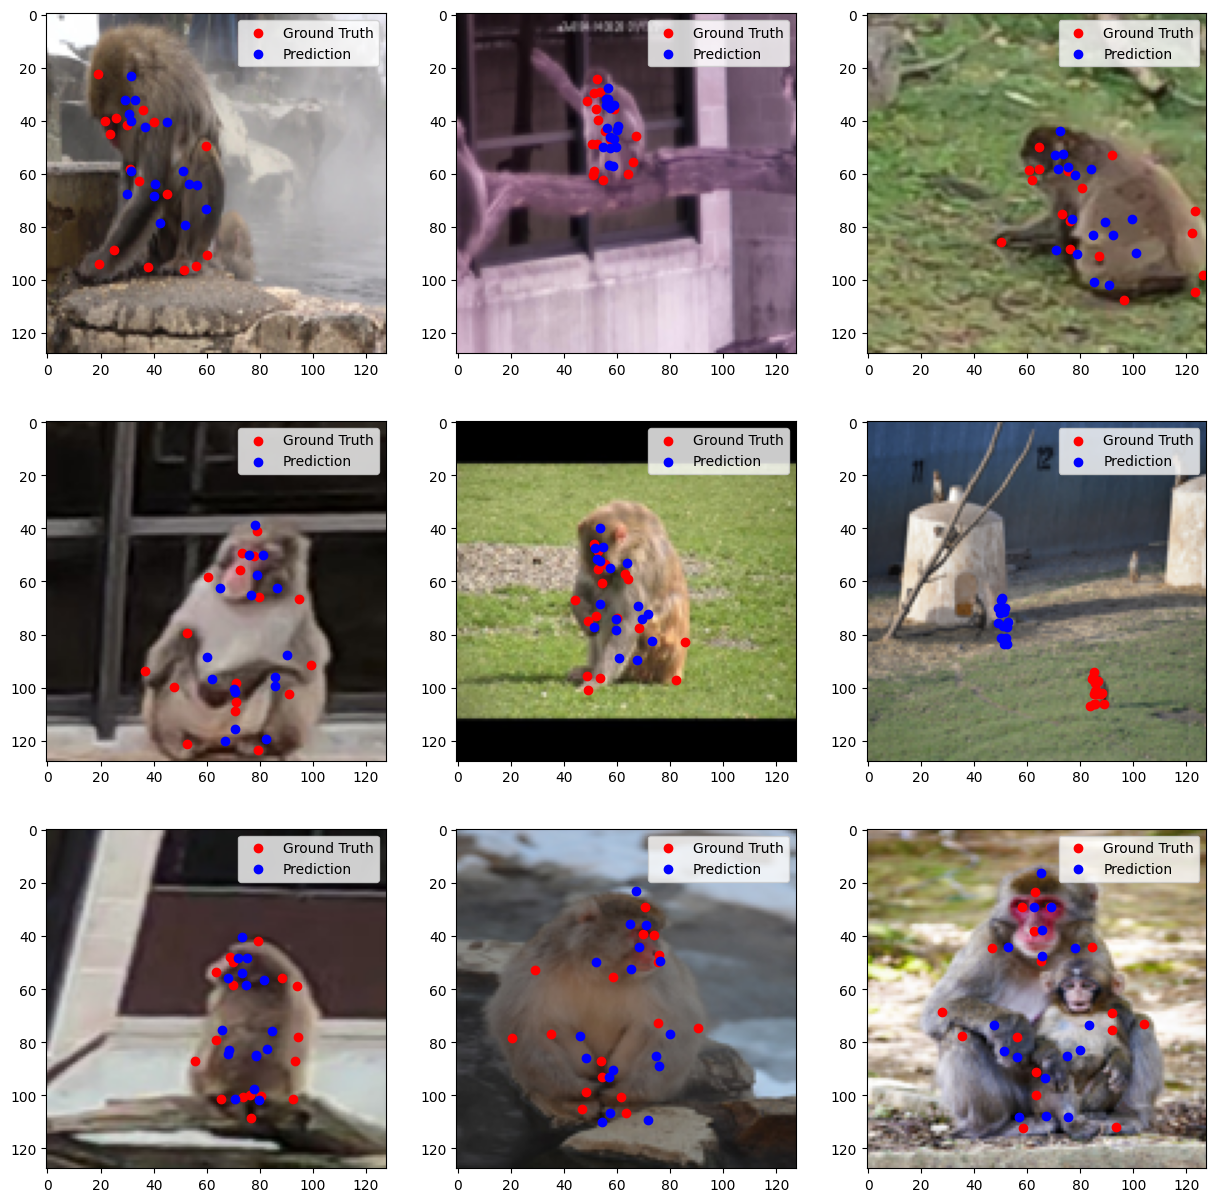

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms


def preprocess_image(image_path, device):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    return input_tensor, image


def infer(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    return output.cpu().numpy()


def plot_landmarks(ax, image, ground_truth_landmarks, predicted_landmarks):
    ax.imshow(image)

    gt_x = ground_truth_landmarks[0::2]
    gt_y = ground_truth_landmarks[1::2]
    ax.scatter(gt_x, gt_y, c='r', label='Ground Truth')

    pred_x = predicted_landmarks[0::2]
    pred_y = predicted_landmarks[1::2]
    ax.scatter(pred_x, pred_y, c='b', label='Prediction')

    ax.legend()


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(9):
    # Load and preprocess the image
    image_path = train_df.iloc[i]["file"]
    input_tensor, image = preprocess_image(image_path, device)

    # Perform inference
    predicted_landmarks = infer(model, input_tensor)[0]

    # Ground truth landmarks
    ground_truth_landmarks = train_df.iloc[i]["landmarks"]

    # Scale ground truth landmarks to the resized image size
    scaling_factor_x = config.IMAGE_WIDTH / image.size[0]
    scaling_factor_y = config.IMAGE_HEIGHT / image.size[1]
    scaled_ground_truth_landmarks = [
        ground_truth_landmarks[i] * scaling_factor_x if i % 2 == 0 else ground_truth_landmarks[i] * scaling_factor_y
        for i in range(len(ground_truth_landmarks))
    ]

    image = image.resize((config.IMAGE_WIDTH, config.IMAGE_HEIGHT))

    # Plot the landmarks
    row = i // 3
    col = i % 3
    plot_landmarks(axes[row, col], image, scaled_ground_truth_landmarks, predicted_landmarks)

plt.show()
